In [64]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Imputation missing values for training data
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# Combine two years dataset, logistic regression

In [30]:
#q="select * from aha_2016_core_ftrs"
#q1='select * from aha_2017_core_ftrs'
#df16=pd.read_sql_query(q,connection)
#df17=pd.read_sql_query(q1,connection)
df14=pd.read_csv("2014CoreFeaturesNew.csv")
df15=pd.read_csv("2015CoreFeaturesNew.csv")


In [31]:
df14.head()

,id,ehr_lessthanbasic,ehr_basic,ehr_comp,hhi_hrr,dsh_index,mus1_met,cmi,urban,cah,...,acp,mortality,skilled_nurs_fac_total_beds,nursing_facilities_total_beds,home_health_agencies,hospices,per_capita_personal_income,persons_in_poverty,without_health_insurance_lessthan65,population_estimate_over65
0,6442400,NaN,NaN,NaN,0.194759,0.00000,True,NaN,True,True,...,NaN,961.0,482.0,0.0,1.0,1.0,34408.0,15003.0,13.0,16078.0
1,6720399,NaN,NaN,NaN,0.128554,0.23743,True,0.9531,True,False,...,NaN,282.0,235.0,0.0,3.0,1.0,36361.0,6281.0,20.0,4227.0
2,6450003,NaN,NaN,NaN,0.193494,0.00000,False,NaN,True,False,...,NaN,1839.0,1299.0,0.0,7.0,6.0,43171.0,29989.0,11.0,32215.0
3,6450016,True,False,False,0.048945,0.00000,False,NaN,True,False,...,0.0,8140.0,4183.0,84.0,26.0,10.0,41017.0,208877.0,14.0,113944.0
4,6450022,True,False,False,0.048945,0.00000,True,1.6699,True,False,...,2.0,8140.0,4183.0,84.0,26.0,10.0,41017.0,208877.0,14.0,113944.0


In [32]:
df14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6239 entries, 0 to 6238
Data columns (total 38 columns):
id                                     6239 non-null object
ehr_lessthanbasic                      3270 non-null object
ehr_basic                              3270 non-null object
ehr_comp                               3270 non-null object
hhi_hrr                                6239 non-null float64
dsh_index                              4952 non-null float64
mus1_met                               5940 non-null object
cmi                                    3322 non-null float64
urban                                  6239 non-null bool
cah                                    6239 non-null bool
region_ne                              6239 non-null bool
region_mw                              6239 non-null bool
region_s                               6239 non-null bool
region_w                               6239 non-null bool
coth                                   6239 non-null bool
staf

In [33]:
df15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6251 entries, 0 to 6250
Data columns (total 38 columns):
id                                     6251 non-null object
ehr_lessthanbasic                      3494 non-null object
ehr_basic                              3494 non-null object
ehr_comp                               3494 non-null object
hhi_hrr                                6251 non-null float64
dsh_index                              2640 non-null float64
mus1_met                               5922 non-null object
cmi                                    3319 non-null float64
urban                                  6251 non-null bool
cah                                    6251 non-null bool
region_ne                              6251 non-null bool
region_mw                              6251 non-null bool
region_s                               6251 non-null bool
region_w                               6251 non-null bool
coth                                   6251 non-null bool
staf

# Logistic approach

In [34]:
dfs_inner=df14.merge(df15,how='inner',on='id',suffixes=('_2014', '_2015'))
dfs_inner['acp_diff']=dfs_inner['acp_2014']-dfs_inner['acp_2015']
dfs_inner.shape

(6162, 76)

In [35]:
#filter out non-null acp_diff records
dfs_inner_diff=dfs_inner[~dfs_inner['acp_diff'].isna()]
dfs_inner_diff.shape

(2567, 76)

In [36]:
dfs_inner_diff.acp_diff.value_counts()

 0.0    2159
-1.0     149
 1.0     109
-2.0      77
 2.0      73
Name: acp_diff, dtype: int64

In [37]:
dfs_inner_diff['acp_change']=np.where(dfs_inner_diff['acp_diff']!=0,1,0)
dfs_inner_diff.isnull().sum()/dfs_inner_diff.shape[0]

C:\Users\soloz\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


id                                          0.000000
ehr_lessthanbasic_2014                      0.000000
ehr_basic_2014                              0.000000
ehr_comp_2014                               0.000000
hhi_hrr_2014                                0.000000
dsh_index_2014                              0.185820
mus1_met_2014                               0.023763
cmi_2014                                    0.366965
urban_2014                                  0.000000
cah_2014                                    0.000000
region_ne_2014                              0.000000
region_mw_2014                              0.000000
region_s_2014                               0.000000
region_w_2014                               0.000000
coth_2014                                   0.000000
staffing_num_phys_2014                      0.241527
staffing_num_nurses_2014                    0.000000
sys_owned_2014                              0.000000
sizehosp_num_discharges_2014                0.

In [38]:
#ids=list(dfs_inner_diff['id'])
#drop complete missing values column
dfs_inner_diff.drop(columns=['id','acp_diff','valueprog_aco_2014','valueprog_aco_2015','staffing_num_apps_2014','acp_2014','acp_2015'],inplace=True)
dfs_inner_diff.select_dtypes(exclude=['int64','float64']).astype("float64",inplace=True)
dfs_inner_diff.shape

C:\Users\soloz\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(2567, 70)

C:\Users\soloz\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


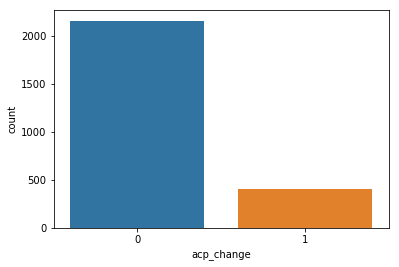

In [39]:
sns.countplot(dfs_inner_diff['acp_change'])
plt.show()

In [62]:
dfs_inner_diff.acp_change.value_counts()

0    2159
1     408
Name: acp_change, dtype: int64

# Treat missing valuees with median 

In [76]:
y=dfs_inner_diff['acp_change']
X=dfs_inner_diff.drop('acp_change',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.3,random_state=42)

In [77]:
X_train.shape, X_test.shape

((1796, 69), (771, 69))

In [78]:
y_train.sum()/len(y_train),y_test.sum()/len(y_test)

(0.15868596881959912, 0.15953307392996108)

In [79]:
def dealoutliner(x,df_new):
   Q1=df_new[x].quantile(0.25)
   Q3=df_new[x].quantile(0.75)
   IQR=Q3-Q1
   df_new[x]=np.where(df_new[x]>(Q3+1.5*IQR),(Q3+1.5*IQR),(np.where(df_new[x]<(Q1-1.5*IQR),(Q1-1.5*IQR),df_new[x])))
   #condlist=[df[x]>(Q3+1.5*IQR),df[x]<(Q1-1.5*IQR),df[x]>=(Q1-1.5*IQR) and df[x]<=(Q3+1.5*IQR)] 
   #choicelist=[Q3,Q1,df[x]]
   #df[x]=np.select(condlist,choicelist)

In [80]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(X_train)
imputed_training=imp.transform(X_train)
imputed_testing=imp.transform(X_test)

X_train_impute=pd.DataFrame(imputed_training,columns=X_train.columns)
X_test_impute=pd.DataFrame(imputed_testing,columns=X_test.columns)

sm=SMOTE(random_state=27,ratio='minority')
X_train_impute, y_train = sm.fit_sample(X_train_impute, y_train)

X_train_impute=pd.DataFrame(X_train_impute,columns=X_train.columns)
cols=X_train.columns
for c in cols:
    dealoutliner(c,X_train_impute)
    dealoutliner(c,X_test_impute)
    

sc = MinMaxScaler()
X_train_impute = sc.fit_transform(X_train_impute)
X_test_impute=sc.transform(X_test_impute)

C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default s

C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default s

C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default s

C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default s

C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default s

C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default s

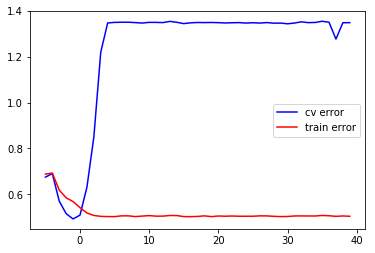

In [81]:
#adjust regularization. Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
alpha=[10**x for x in np.arange(-5, 40, dtype=float)]
log_alpha=np.arange(-5,40)

cv_err=[]
train_err=[]
for a in alpha:
    clf=LogisticRegression(C=a, penalty='l2', class_weight={1:5,0:1})
    clf.fit(X_train_impute, y_train)
    sig_clf=CalibratedClassifierCV(clf)
    sig_clf.fit(X_train_impute, y_train)
    
    predict_y=sig_clf.predict_proba(X_test_impute)
    cv_err.append(log_loss(y_test, predict_y))
    
    predict_y=sig_clf.predict_proba(X_train_impute)
    train_err.append(log_loss(y_train, predict_y))

plt.plot(log_alpha, cv_err, label='cv error', c='b')
plt.plot(log_alpha, train_err, label='train error', c='r')
plt.legend()
plt.show()

[[294 354]
 [ 19 104]]


C:\Users\soloz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


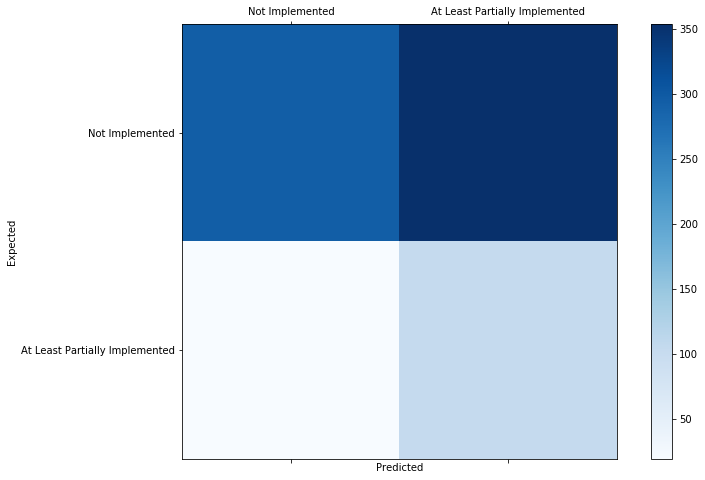

In [86]:
clf=LogisticRegression(C=alpha[np.argmin(cv_err)], penalty='l2', class_weight={1:5,0:1})
clf.fit(X_train_impute, y_train)
y_pred=clf.predict(X_test_impute)
y_pred_label =(y_pred>0.5)
cm = confusion_matrix(y_test, y_pred_label)
print(cm)

labels = ['Not Implemented', 'At Least Partially Implemented']
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [87]:
columns=list(X.columns)

In [88]:
feature_importance=pd.DataFrame(np.hstack((np.array([columns]).T, clf.coef_.T)), columns=['feature', 'importance'])
feature_importance['importance']=pd.to_numeric(feature_importance['importance'])
feature_importance.sort_values(by='importance', ascending=False,inplace=True)
feature_importance.to_csv("logistic_impt_2014_2015_New.csv",index=False)
feature_importance

,feature,importance
35,ehr_basic_2015,2.281053
34,ehr_lessthanbasic_2015,1.490430
55,own_np_2015,0.652265
0,ehr_lessthanbasic_2014,0.578627
17,sizehosp_num_discharges_2014,0.541979
23,own_gov_2014,0.513476
62,nursing_facilities_total_beds_2015,0.441064
59,staffing_num_apps_2015,0.425987
64,hospices_2015,0.402728
27,nursing_facilities_total_beds_2014,0.337903


# Random Forest Algorithm

Accuracy: 0.8443579766536965
[[641   7]
 [113  10]]


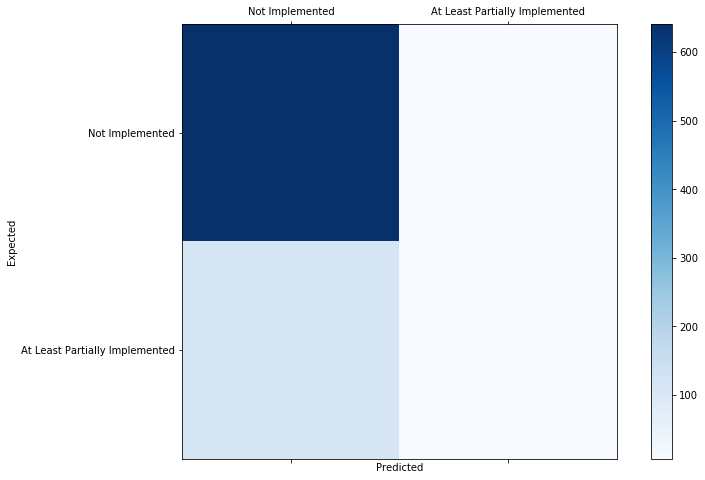

              precision    recall  f1-score   support

           0       0.85      0.99      0.91       648
           1       0.59      0.08      0.14       123

   micro avg       0.84      0.84      0.84       771
   macro avg       0.72      0.54      0.53       771
weighted avg       0.81      0.84      0.79       771



In [89]:
clf=RandomForestClassifier(n_estimators=100,class_weight={1:9,0:1})
clf.fit(X_train_impute,y_train)
y_pred=clf.predict(X_test_impute)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#y_pred=model.predict(X_test_impute)
y_pred_label =(y_pred>0.5)
cm = confusion_matrix(y_test, y_pred_label)
print(cm)

labels = ['Not Implemented', 'At Least Partially Implemented']
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

print(classification_report(y_test,y_pred_label))
rf_ft_imp=list(clf.feature_importances_)

dt={'feature':columns,'importance':rf_ft_imp}
feature_imp=pd.DataFrame(dt, columns=['feature', 'importance'])
feature_imp.sort_values(by='importance',ascending=False,inplace=True)

In [90]:
feature_imp

,feature,importance
36,ehr_comp_2015,0.077204
2,ehr_comp_2014,0.047735
0,ehr_lessthanbasic_2014,0.043865
52,sizehosp_visits_plus_adm_2015,0.037433
18,sizehosp_visits_plus_adm_2014,0.035621
34,ehr_lessthanbasic_2015,0.032879
17,sizehosp_num_discharges_2014,0.027846
35,ehr_basic_2015,0.027607
37,hhi_hrr_2015,0.027422
30,per_capita_personal_income_2014,0.027417


In [52]:
feature_imp.to_csv("RF_MedianPro_2014_2015.csv",index=False)